#문서 벡터를 이용한 추천 시스템

문서를 문서 벡터로 변환한다면, 문서들을 서로 비교할 수 있다. Doc2Vec, Sent2Vec을 학습할 수 있지만, 문서 안 단어들의 벡터의 평균을 이용하여 문서 벡터로 변환할 수 있다.

-> Word2Vec을 사용해 문서 내 단어들을 벡터로 바꿔 문서 전체의 평균 벡터를 얻고, 그 도서와 유사한 도서를 찾아주는 도서 추천 시스템을 만들 수 있다.

In [16]:
import gensim
import nltk

#Data load

In [4]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Pytorch_Study/자연어처리pytorch/BookSummaryData.csv")
print('전체 문서의 수 :',len(df))


전체 문서의 수 : 2382


In [10]:
df[:5]

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


Desc ( Description ) 정보가 제일 중요하기 때문에 이에 대해 전처리를 한다

In [13]:
df['Desc'][:5]

0    We know that power is shifting: From West to E...
1    Following the success of The Accidental Billio...
2    How to tap the power of social software and ne...
3    William J. Bernstein is an American financial ...
4    Amazing book. And I joined Steve Jobs and many...
Name: Desc, dtype: object

In [19]:
def removeNonAscii(s):
  return "".join(i for i in s if ord(i)<128)

def make_lower_case(text):
  return text.lower()

def remove_stopwords(text):
  text = text.split()
  stops = set(stopwords.words("english"));
  text = [w for w in text if not w in stops]
  text = " ".join(text)
  return text

def remove_html(text):
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r'', text)

def remove_punctuation(text):
  tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
  text = tokenizer.tokenize(text)
  text = " ".join(text)
  return text

df['cleaned'] = df['Desc'].apply(removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stopwords)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)


In [20]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [28]:
if (df['cleaned'].isna().any()):
  print("Na Exist")
else:
  print("Na does not exist")

Na does not exist


In [29]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print("전체 문서의 수: ", len(df))

전체 문서의 수:  2381


In [30]:
corpus = []
for words in df['cleaned']:
  corpus.append(words.split())

In [36]:
corpus

Output hidden; open in https://colab.research.google.com to view.

#Pretrained Word Embedding 사용하기

만든 corpus와 사전훈련된 모델까지 합쳐 성능을 더 좋게 하자.

In [32]:
!pip install gdown

In [39]:
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=3)
word2vec_model.build_vocab(corpus)
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.wv.intersect_word2vec_format('/content/drive/MyDrive/Pytorch_Study/자연어처리pytorch/GoogleNews-vectors-negative300.bin.gz', binary=True)
word2vec_model.train(corpus, total_examples =len(corpus), epochs = 15)


(3695313, 3981030)

#단어 벡터의 평균 구하기

In [43]:
def get_document_vectors(document_list):
  #문서 embedding vector 구하기
  document_embedding_list = []

  for line in document_list: #df['Desc']의 모든 값에 대
    doc2vec = None
    count = 0
    for word in line.split():
      if word in list(word2vec_model.wv.index_to_key):
        count+=1 #문서 길이 계산
        if doc2vec is None:
          doc2vec = word2vec_model.wv[word]
        else:
           doc2vec = doc2vec + word2vec_model.wv[word]
    if doc2vec is not None:
      doc2vec = doc2vec / count
      document_embedding_list.append(doc2vec)
  return document_embedding_list

In [44]:
document_embedding_list = get_document_vectors(df['cleaned'])
print("문서 벡터의 수 : ",len(document_embedding_list))

문서 벡터의 수 :  2381


#추천 시스템 구현하기

In [45]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print("코사인 유사도 매트릭스의 크기: ", cosine_similarities.shape)


코사인 유사도 매트릭스의 크기:  (2381, 2381)


In [53]:
def recommendations(title):
  books = df[['title', 'image_link']]

  indices = pd.Series(df.index, index=df['title']).drop_duplicates()
  idx = indices[title] #입력한 제목의 index 구하기

  sim_scores = list(enumerate(cosine_similarities[idx]))
  sim_scores = sorted(sim_scores, key= lambda x: x[1], reverse=True) #similarity에 대해서 sort
  sim_scores = sim_scores[1:6] #자기 자신을 제외한 top 5

  book_indices = [i[0] for i in sim_scores] #top 5 index 뽑기

  recommend = books.iloc[book_indices].reset_index(drop=True) #index를 다시 0부터 시작하게

  fig = plt.figure(figsize=(20,30))

  for index, row in recommend.iterrows():
    response = requests.get(row['image_link'])
    img = Image.open(BytesIO(response.content))
    fig.add_subplot(1,5,index+1)
    plt.imshow(img)
    plt.title(row['title'])






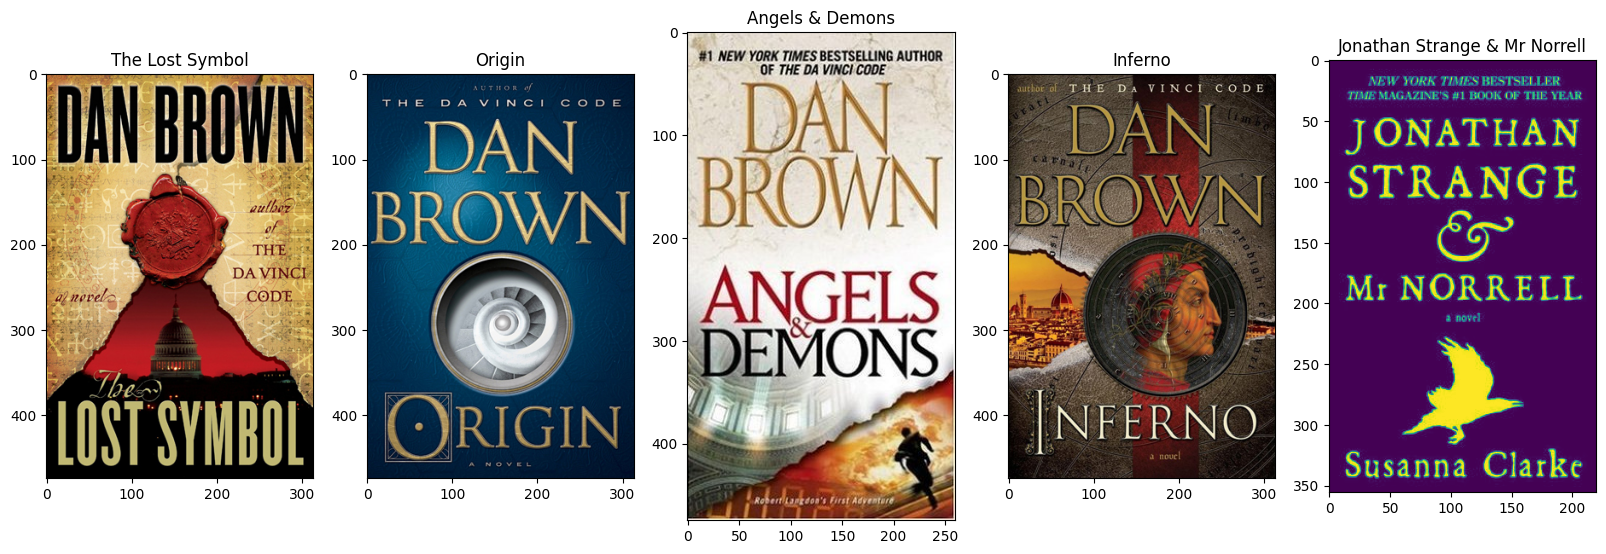

In [55]:
recommendations("The Da Vinci Code")